In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

In [3]:
def plot_environment(env):
    plt.imshow(env, cmap='binary')
    plt.show()

def get_circle(radius, center, env_size):
    layer = np.zeros(env_size)
    for y in range(env_size[0]):
        for x in range(env_size[0]):
            if (y - center[0])**2+(x - center[1])**2 <= radius**2:
                layer[y,x] = 1
    return layer

In [ ]:
def random_circle_dynamic_env(env_size, n_circles, n_frames = 1):
    frame_list = []
    object_list = []

    # initialization of environment and objects
    
    for i in range(n_circles):
        radius = np.random.choice(np.arange(10))
        center_y, center_x = np.random.choice(np.arange(env_size[0])), np.random.choice(np.arange(env_size[0]))
        circle = get_circle(radius, (center_y, center_x), env_size)
        object_list.append(circle)
    frame = sum(object_list)
    frame_list.append(frame)
    # plot_environment(frame)

    object_dict = dict()
    if n_frames > 1:
        moving_objects = []
        static_objects = []
        for object in object_list: # 50% of the objects are moving
            if np.random.random() > 0.5:
                moving_objects.append(object)
            else:
                static_objects.append(object)
        
        
        for id, object in enumerate(moving_objects): # each object gets a direction, speed
        
            direction = np.random.choice(('UP', 'DOWN', 'LEFT', 'RIGHT'))
            speed = np.random.choice(np.arange(1,4))
            object_dict[id] = (direction, speed)
        
        for frame in range(1,n_frames):
            updated_moving_objects = []
            for id, object in enumerate(moving_objects):
                direction, speed = object_dict[id]
                updated_object = np.zeros(env_size)

                reset = False
                for y in range(env_size[0]):
                    for x in range(env_size[0]):
                        if object[y][x] == 1:
                            match direction:
                                case 'UP': 
                                    if y >= speed:
                                        updated_object[y-speed][x] = 1
                                    else:
                                        object_dict[id] = 'DOWN' , speed
                                        reset = True
                                case 'DOWN': 
                                    if y < env_size[0] - speed:
                                        updated_object[y+speed][x] = 1
                                    else:
                                        object_dict[id] = 'UP', speed
                                        reset = True
                                case 'LEFT': 
                                    if x >= speed:
                                        updated_object[y][x-speed] = 1
                                    else:
                                        object_dict[id] = 'RIGHT', speed
                                        reset = True
                                case 'RIGHT': 
                                    if x < env_size[0] - speed:
                                        updated_object[y][x+speed] = 1
                                    else:
                                        object_dict[id] = 'LEFT', speed
                                        reset = True
                if reset: 
                    updated_object = object
                updated_moving_objects.append(updated_object)
            moving_objects = updated_moving_objects
            frame = sum((*moving_objects, *static_objects))
            frame_list.append(frame)
    return frame_list

                            



frame_list = random_circle_dynamic_env((64,64), 10, 20)

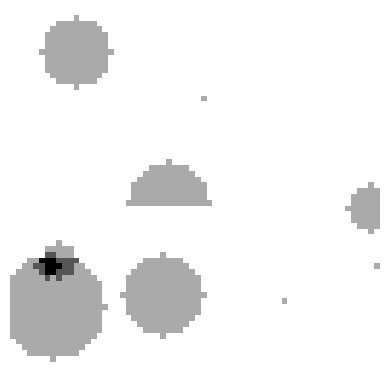

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

frames = []

for frame in frame_list:
    plt.imshow(frame, cmap='binary')
    plt.axis('off')


    plt.savefig("temp.png", bbox_inches='tight', pad_inches=0)
    frames.append(Image.open("temp.png"))

# save as GIF
frames[0].save(
    "maze_animation.gif",
    save_all=True,
    append_images=frames[1:],
    duration=100,
    loop=0
)